# Linear Model

The linear method makes use of the log backward return (log price difference) to predict foward return.

Training:
1) Ridge regression: on 30 features
2) PC regression: pca on 30 features then perform ols

Feature: 10 stocks, each with 3 backward return (say, 3min, 7min, 10min, see correlation to decide)

Response: 10 stocks' 30min forward return. 

Groups: [1,3,5,9],[2,4,7],[0],[3],[9]

## Data Preparation

In [2]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

In [31]:
# get feature for train and validation set
def wide_format(df):
    df_= df.reset_index(level=['stock']).sort_index()
    df_ = df_.pivot(columns ='stock')
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_


def get_feature_train(log_pr, volu, x_begin_idx, x_end_idx, y_begin_idx, 
                        grp_idx=None, rm_outlier=False, print_cor=True):
    """
    Input:
    log_pr (pdSeries): train set
    volu (pdSeries): train set
    x_begin_idx (pdIndex): to truncate the NaNs
    grp_idx (dict): key is group idx, value is list of stock idx

    Returns:
    feature_dict (dict): key is group idx, value is a tuple of feature matrix and response
    """

    log_pr_df = log_pr.reset_index().melt(id_vars=['timestamp'])
    log_pr_df.columns = ['timestamp', 'stock', 'log_pr']
    log_pr_df = log_pr_df.set_index(['timestamp', 'stock']).sort_index()

    volu_df = volu.reset_index().melt(id_vars=['timestamp'])
    volu_df.columns = ['timestamp', 'stock', 'volu']
    volu_df = volu_df.set_index(['timestamp', 'stock']).sort_index()

    features = pd.DataFrame(index=log_pr_df.index)
    # log_pr feature
    for i in [3, 10, 20, 30]:
        features['log_pr_{}'.format(i)] = -log_pr_df.groupby(level='stock').log_pr.diff(i)

    std_10 = lambda x: x.rolling(10).std()
    features['log_pr_std_10'] = log_pr_df.groupby(level='stock').log_pr.apply(std_10)

    # volume feature
    log_fn = lambda x: np.log(x+1)
    features['log_volu'] = volu_df.groupby(level='stock').volu.apply(log_fn)

    # stdised volume in 2 hours backward rolling windows
    zscore_fn = lambda x: (x - x.rolling(window=240, min_periods=20).mean()) / x.rolling(window=240, min_periods=20).std()
    features['volu_z_score'] = volu_df.groupby(level='stock').volu.apply(zscore_fn)

    feature_dropped = features[x_begin_idx:x_end_idx]
    response_dropped = log_pr.diff(30)[y_begin_idx:]

    if grp_idx is not None:
        feature_dict = {}
        for key, idx_lis in grp_idx.items():
            feature_df_dropped = feature_dropped.loc[pd.IndexSlice[:,idx_lis],:]
            # transform back to wide format
            feature_dict[key] = (wide_format(feature_df_dropped), response_dropped[idx_lis])
        return feature_dict
    else:
        # transform back to wide format
        feature_df_dropped = wide_format(feature_dropped)
    
        if print_cor:
            for i in range(10):
                feature_train_0 = feature_dropped.xs(i, level='stock')
                print(feature_train_0.corrwith(response_dropped[i]))

        return feature_df_dropped, response_dropped


In [32]:
# split into groups
grp_idx = {0:[1,4,5,6,8], 1:[2,7], 2:[3], 3:[9]}
x_begin_idx = log_pr.index[30]
x_end_idx = log_pr.index[-31]
y_begin_idx = log_pr.index[60]

train_vali_idx = log_pr.index[-44641]
feature_dict = get_feature_train(log_pr[:log_pr.index[-44641]], volu[:log_pr.index[-44641]],
                                    x_begin_idx, x_end_idx, y_begin_idx, grp_idx=grp_idx)

In [3]:
# Data Preparation
def logr(dta,min):
    return dta.diff(min,0).dropna()
x_begin_idx = log_pr.index[30]
x_end_idx = log_pr.index[-31]
y_begin_idx = log_pr.index[60]
group1 = [1,5,6,8]

# Group 1: {1,5,6,8}
x = pd.concat((logr(log_pr[group1],10)[x_begin_idx:x_end_idx],
                logr(log_pr[group1],20)[x_begin_idx:x_end_idx],
                logr(log_pr[group1],30)[x_begin_idx:x_end_idx]),axis=1)
y = log_pr[group1].diff(30)[y_begin_idx:]
y = y.set_index(x.index)

xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

In [26]:
# Group 2:
group2 = [0, 3]
x = pd.concat((logr(log_pr[group2],10)[x_begin_idx:x_end_idx],
                logr(log_pr[group2],20)[x_begin_idx:x_end_idx],
                logr(log_pr[group2],30)[x_begin_idx:x_end_idx]),axis=1)
y = log_pr[group2].diff(30)[y_begin_idx:]
y = y.set_index(x.index)

xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

## Ridge Regression

### Model Tuning (MSE and Correlation) 

[]

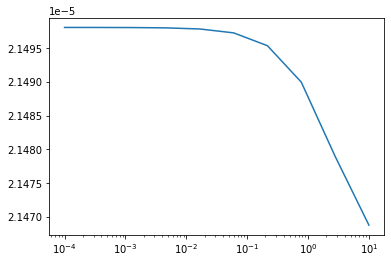

In [27]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_grid = np.logspace(-4,1,10)
mse = np.empty(alpha_grid.shape[0])
for i in range(alpha_grid.shape[0]):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in group2},index=yvali.index)
    mse[i] = mean_squared_error(yvali,yvali_hat_ridge_a)
plt.plot(alpha_grid,mse)
plt.semilogx()

In [28]:
min_idx = np.argmin(mse)
min_alpha = alpha_grid[min_idx]
print(min_alpha)

10.0


In [29]:
rr = Ridge(alpha=min_alpha).fit(xtrain,ytrain)
# 10-minute-rolling 30-min log-return prediction for validation set
yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in group2},index=yvali.index)
# compute pairwise correlation
print(yvali_hat_ridge.corrwith(yvali[::10]))
#print(np.corrcoef(yvali_hat_ridge[::10],yvali[::10])[0,1])
# Compute mse
#from sklearn.metrics import mean_squared_error
#mean_squared_error(yvali,yvali_hat_ridge)

0    0.038067
3    0.017249
dtype: float64


In [30]:
# Refitting the model with train&vali set
rr = Ridge(alpha=min_alpha).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A): 
    x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.array(group2), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat)#,np.corrcoef(r_fwd_all, r_hat_all)[0,1]

log_pr_test = log_pr[group2][log_pr.index[-44640]:]
evaluate(log_pr_test)

Time used:  3.337266206741333


0   -0.021089
3   -0.001528
dtype: float64

### Ridge Test Evaluation

In [20]:
# Refitting the model with train&vali set
rr = Ridge(alpha=min_alpha).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A): 
    x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.array(group2), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat)#,np.corrcoef(r_fwd_all, r_hat_all)[0,1]

log_pr_test = log_pr[group2][log_pr.index[-44640]:]
evaluate(log_pr_test)

Time used:  3.317732095718384


0    0.014766
2   -0.047266
3    0.023596
7   -0.023641
9    0.041775
dtype: float64